```{eval-rst}
.. include:: sinebow.rst

```
{sinebow20}`N-color`
=====================

Here I will argue that many of the errors I see in ground-truth datasets can be most kindly attributed to a lack of good label visualization. To illustrate, here is a moderately dense field of view:

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


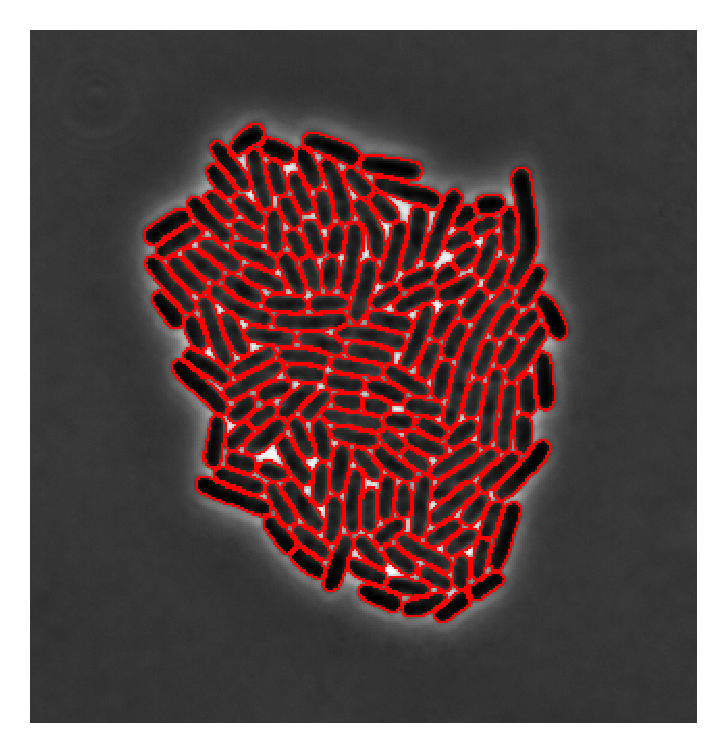

In [ ]:
# make local editable packages automatically reload
%load_ext autoreload
%autoreload 2
        
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import numpy as np
from omnipose.utils import rescale, crop_bbox, imshow
import fastremap

from pathlib import Path
import os
from cellpose_omni import io, plot

basedir = os.path.join(Path.cwd(),'test_files') #run the mono_channel_bact notebook to generate masks
masks = io.imread(os.path.join(basedir,'masks','ec_5I_t141xy5c1_cp_masks.tif'))
img = io.imread(os.path.join(basedir,'ec_5I_t141xy5c1.tif'))
imshow(plot.outline_view(img,masks),3,interpolation='None')


This outline view clearly distinguishes cells from each other, and it requires just one color (or channel). As ground truth, binary maps like this are one of the easiest annotations to generate and are therefore quite common in public datasets (see MiSiC, DeLTA, and SuperSegger just for a few in the realm of bacterial microscopy). However, this mode of annotation does not guarantee that shared boundaries between two cells are **precisely** 2px thick. Without this, the resulting label matrix will either exclude boundary pixels or asymmetrically incorporate them into one of the two cells. This is a primary reason why label matrices, not boundary maps, must be the primary / fundamental ground truth used to train and evaluate any segmentation algorithm. 

However, creating and editing label matrices has its own set of issues. If you have too many cells in an image, you quickly run out of distinct colors to distinguish adjacent cells:

number of masks:  164


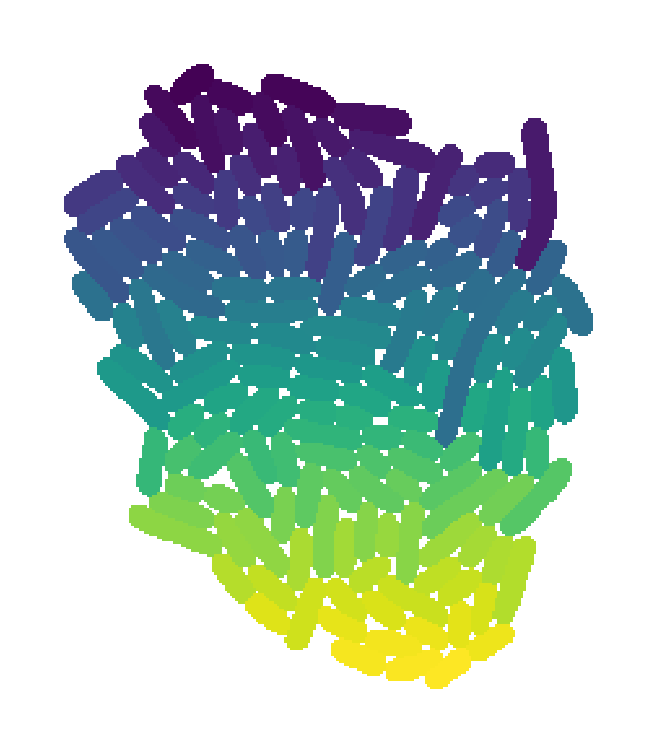

In [ ]:
bbx = crop_bbox(masks) #in omni
slc = bbx[0]
m,_ = fastremap.renumber(masks[slc]) # make sure masks go from 0 to N
print('number of masks: ', np.max(m))

cmap = mpl.cm.get_cmap('viridis')
pic = cmap(rescale(m))
pic[:,:,-1] = m>0 # alpha 
imshow(pic,3,interpolation='None')

This perceptually uniform color map is our best bet of distinguishing cells from each other, but some close cells are too similar to tell apart. The standard technique is to randomly shuffle the labels:

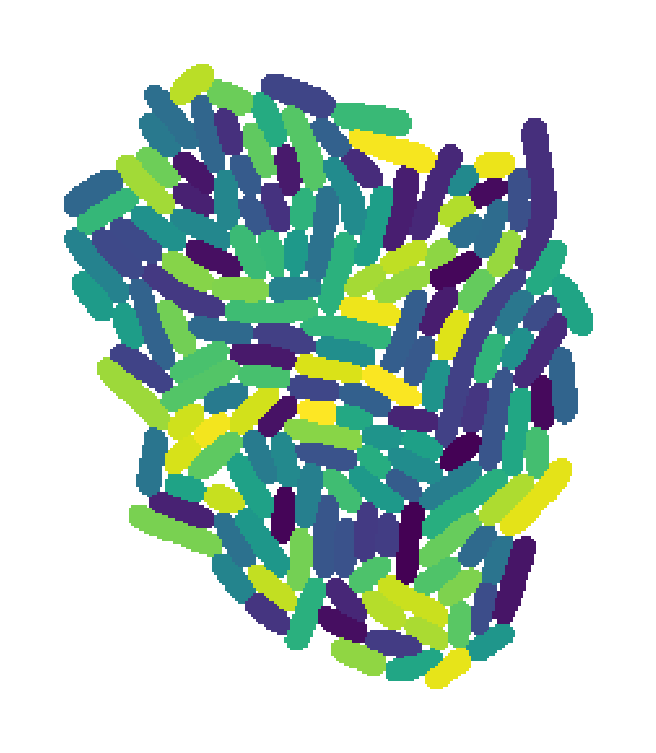

In [ ]:
keys = fastremap.unique(m)
vals = keys.copy()
np.random.seed(42)
np.random.shuffle(keys)
d = dict(zip(keys,vals))
m_shuffle = fastremap.remap(m,d)
pic = cmap(rescale(m_shuffle))
pic[:,:,-1] = m>0 # alpha 
imshow(pic,3,interpolation='None')

This doesn't fix the problem. You might think that adding more colors would help...

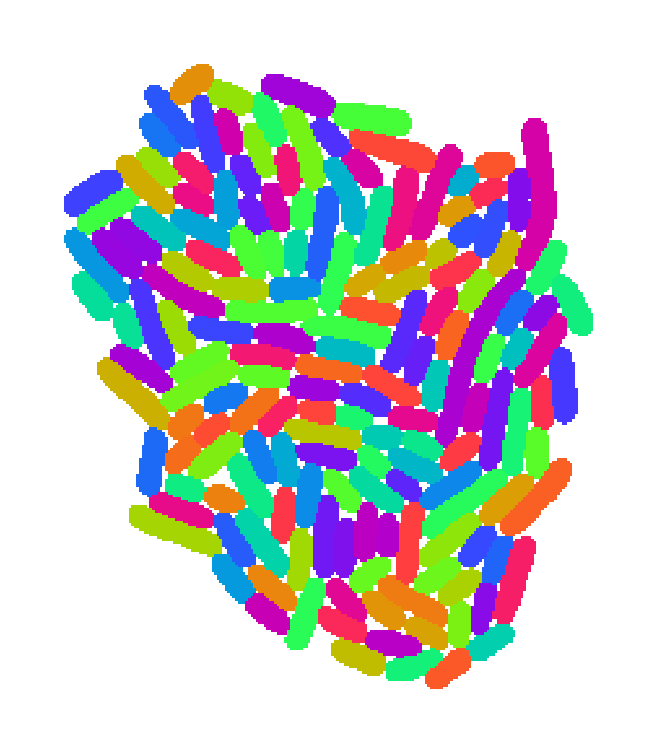

In [ ]:
from omnipose.utils import sinebow
from matplotlib.colors import ListedColormap

cmap = ListedColormap([color for color in list(sinebow(m.max()).values())[1:]])
pic = cmap(m_shuffle)
pic[:,:,-1] = m>0 # alpha 
imshow(pic,3,interpolation='None')

... but since even random shuffling *does not guarantee* that numerically close labels become spatially separated, adjacent labels that were hard to tell apart using a perceptually uniform color map like viridis are often *more difficult* to tell apart using any kind of unicorn-vomit color map. 

Worse still, multiple similar colors can accidentally get used while editing the *wrong cell* (*e.g.*, color 11 inside cell 12 that are both shades of yellow) and ruin the segmentation despite this error being imperceptible 
to the human eye (this may account for many of the "errant pixels" we observe across ground-truth datasets of dense cells). 

To solve this problem, I developed the `ncolor` package, which converts $K$-integer label matrices to $N \ll K$ - color labels. The `four color theorem` guarantees that you only need 4 unique cell labels to cover all cells, but my algorithm opts to use 5 if a solution using 4 is not found quickly.
This was integral in developing the BPCIS dataset, and I subsequently incorporated it into Cellpose and Omnipose. By default, the GUI and plot commands display N-color 
masks for easier visualization and editing:

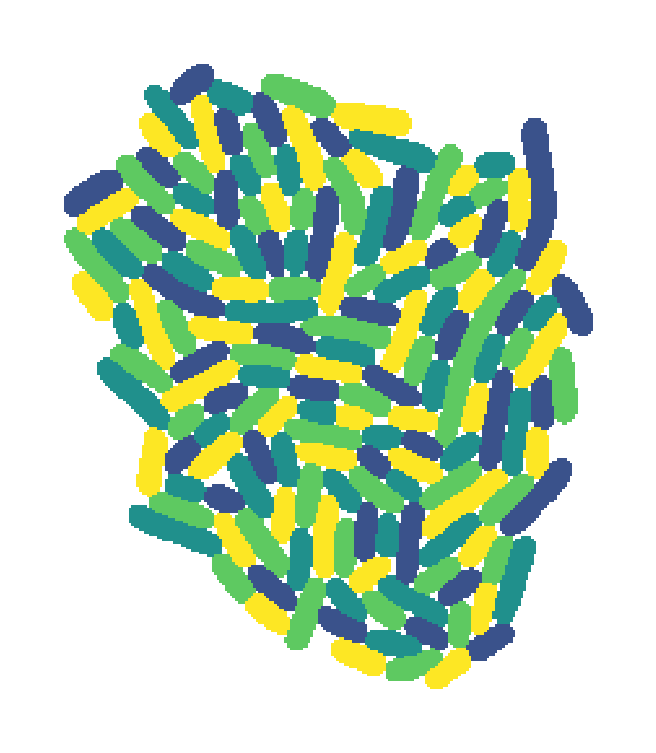

In [ ]:
import ncolor 
cmap = mpl.cm.get_cmap('viridis')
pic = cmap(rescale(ncolor.label(m)))
pic[:,:,-1] = m>0 # alpha 
imshow(pic,3,interpolation='None')

Interesting note: my code works for 3D volume labels as well, but there is no analogous theorem guaranteeing any sort of upper bound $N<K$ in 3D. 
In 3D, you could in principle have cells that touch every other cell, in which case $N=K$ and you cannot "recolor your map". On the dense but otherwise 
well-behaved volumes I have tested, my algorithm ends up needing 6-7 unique labels. I am curious if some bound on N can be formulated in the context of constrained volumes,
*e.g.*, packed spheres of mixed and arbitrary diameter...

Final note: thanks to Ryan Peters for suggesting a fix for displaying segmentations that (a) are from ground-truth sets with pixel-separated (boundary-map-generated) label matrices or (b) have many sparse, disjoint objects. By expanding labels before coloring them (a step that actually takes far longer than the coloring step itself), we get a much more pleasing distribution of colors that can make it easier to assess segmentations when when images are zoomed out. For example, 

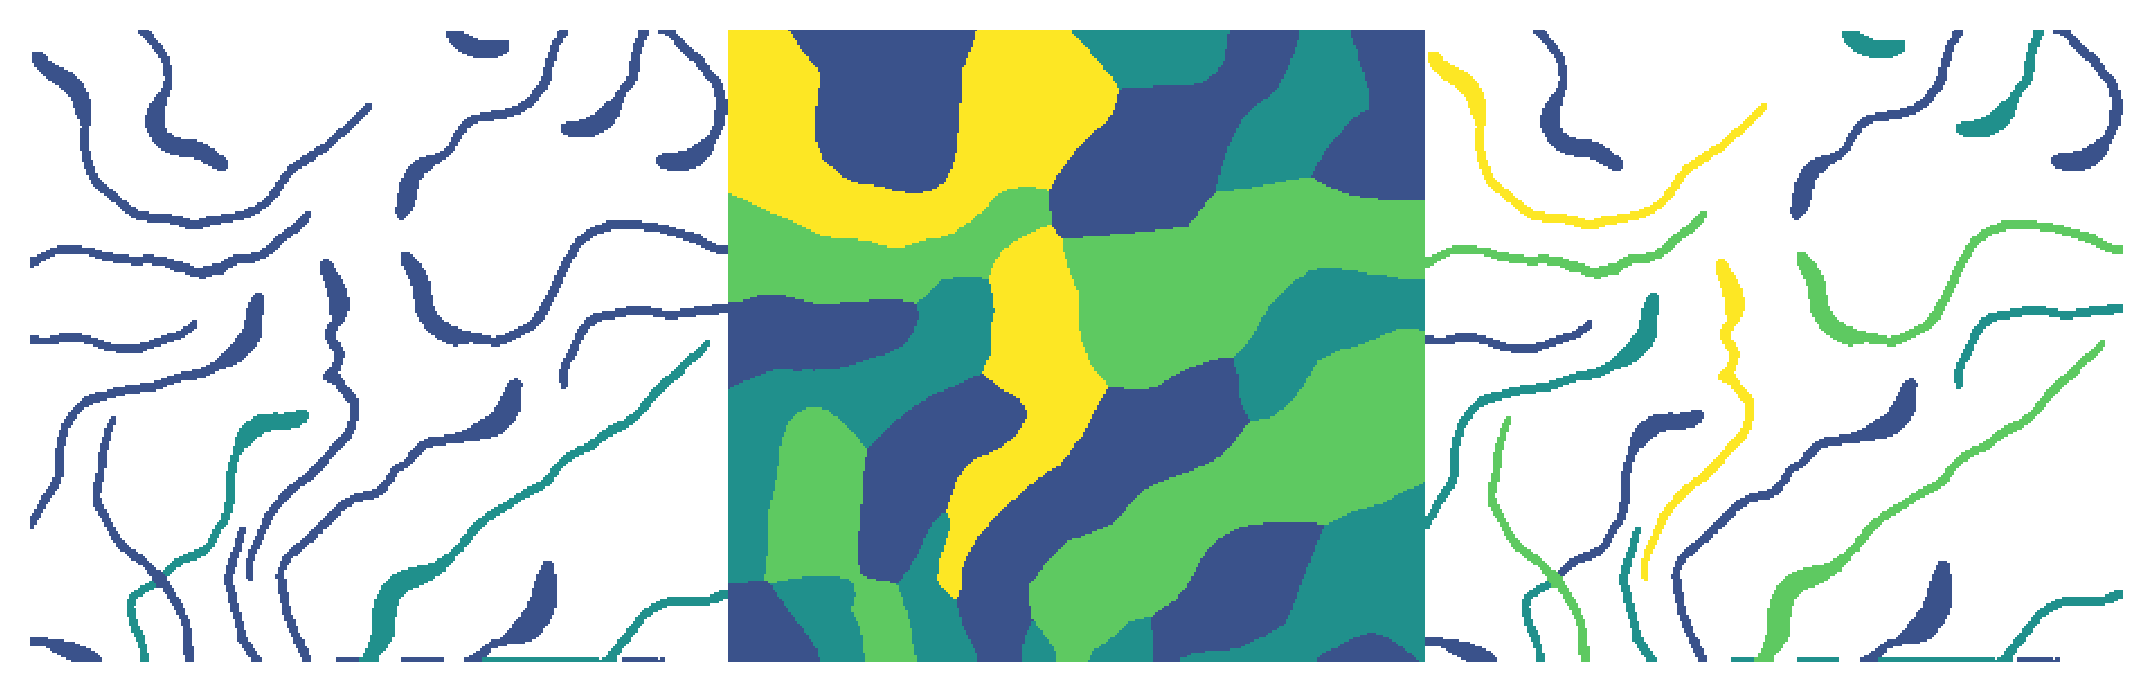

In [ ]:
masks = io.imread(os.path.join(basedir,'masks','caulo_15_cp_masks.tif'))
exp = ncolor.expand_labels(masks)
pic = cmap(rescale(np.hstack([ncolor.label(masks,expand=False),ncolor.label(exp),ncolor.label(masks)])))
pic[:,:,-1] = np.hstack([masks,exp,masks])>0 # alpha 
imshow(pic,9,interpolation='None')

(Left: ncolor applied to raw masks. Middle: ncolor expanded masks. Right: current version of ncolor). Note that the expansion step takes about 2x longer than the ncolor algorithm itself takes to run, but the extra milliseconds are worth it. If you know of any faster way to get a feature transform than `scipy.ndimage`, please let me know. 